In [1]:
# Base de datos y kernel de lectura y visualización de la base de datos obtenidos de:
#
# https://www.kaggle.com/kmader/lungnodemalignancy

import os
import numpy as np
#from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
from skimage.color import label2rgb
import h5py

%matplotlib inline

In [3]:
data_path = os.path.join('data')

with h5py.File(os.path.join(data_path, 'all_patches.hdf5'), 'r') as luna_h5:
    all_slices = luna_h5['ct_slices'].value
    all_classes = luna_h5['slice_class'].value
    print('shape of all_slices:', all_slices.shape)
    print('shape of classes:   ', all_classes.shape)

shape of all_slices: (6691, 64, 64)
shape of classes:    (6691, 1)


In [14]:
(all_classes==1).sum()
#(all_classes==0).sum()

2526

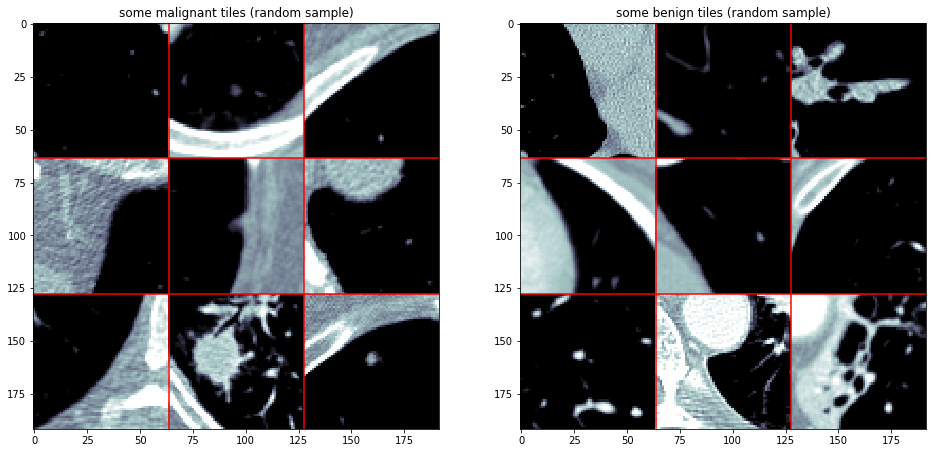

In [4]:
def draw_borders(ax, ntiles, tile_width, tile_height, color='r'):
    
    aux1 = int(np.ceil(np.sqrt(ntiles)))
    
    npixels_y = tile_height*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_width - 0.5
        ax.plot([aux2, aux2], [0, npixels_y - 1], color)
        
    npixels_x = tile_width*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_height - 0.5
        ax.plot([0, npixels_x - 1], [aux2, aux2], color)
        

from skimage.util.montage import montage2d

size = 9
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16, 8))
plt_args = dict(cmap = 'bone', vmin = -600, vmax = 300)
#plt_args = dict(cmap = 'bwr', vmin = -600, vmax = 300)
ax1.imshow(montage2d(all_slices[np.random.choice(np.where(all_classes>0.5)[0],size=size)]), **plt_args)
ax1.set_title('some malignant tiles (random sample)')
draw_borders(ax1, size, all_slices.shape[1], all_slices.shape[2], 'r')

ax2.imshow(montage2d(all_slices[np.random.choice(np.where(all_classes<0.5)[0],size=size)]), **plt_args)
ax2.set_title('some benign tiles (random sample)')
draw_borders(ax2, size, all_slices.shape[1], all_slices.shape[2], 'r')

plt.show()

# Partition and reformat the data
We want to partition the data into training and validation datasets and then reform the class as a one-hot so it fits to the model. We also perform a simple normalization of the image data so the range is between -1 and 1 instead of -3000 to 2000

In [5]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_vec = (np.expand_dims(all_slices,-1) - np.mean(all_slices))/np.std(all_slices)

y_vec = to_categorical(all_classes)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, 
                                                   train_size = 0.75,
                                                   random_state = 1, 
                                                   stratify = all_classes)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Standard model

In [6]:
X_tr = np.zeros((np.shape(X_train)[0], np.shape(X_train)[1]*np.shape(X_train)[2]))
for i in range(np.shape(X_train)[0]):
    X_tr[i] = X_train[i].flatten()
X_te = np.zeros((np.shape(X_test)[0], np.shape(X_test)[1]*np.shape(X_test)[2]))
for i in range(np.shape(X_test)[0]):
    X_te[i] = X_test[i].flatten()

print("X_train shape:", np.shape(X_train))
print("X_tr shape:   ", np.shape(X_tr))
print("X_test shape: ", np.shape(X_test))
print("X_te shape:   ", np.shape(X_te))

X_train shape: (5018, 64, 64, 1)
X_tr shape:    (5018, 4096)
X_test shape:  (1673, 64, 64, 1)
X_te shape:    (1673, 4096)


In [7]:
from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression()

model2.fit(X_tr, np.argmax(y_train,1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
print('Train accuracy:', model2.score(X_tr, np.argmax(y_train,1)))
print('Test accuracy :', model2.score(X_te, np.argmax(y_test,1)))

Train accuracy: 0.989039457951
Test accuracy : 0.744172145846



             precision    recall  f1-score   support

          0       0.80      0.78      0.79      1041
          1       0.65      0.69      0.67       632

avg / total       0.75      0.74      0.75      1673



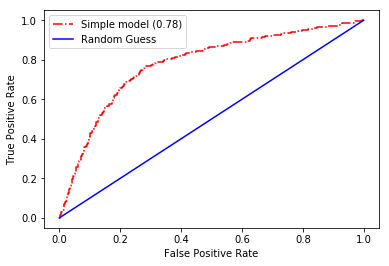

In [9]:
from sklearn.metrics import classification_report, roc_curve, auc

print('')
print(classification_report(np.argmax(y_test,1),
                            model2.predict(X_te)))

fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), model2.predict_proba(X_te)[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Simple model (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

# Defining the CNN architecture

The model will be trained from scratch although it is often a good idea to fine-tune pretrained models.

In [10]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.losses import binary_crossentropy
from keras import optimizers

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [11]:
print("X_train shape:", np.shape(X_train))
print("X_test shape: ", np.shape(X_test))
print("y_train shape:", np.shape(y_train))
print("y_test shape: ", np.shape(y_test))

X_train shape: (5018, 64, 64, 1)
X_test shape:  (1673, 64, 64, 1)
y_train shape: (5018, 2)
y_test shape:  (1673, 2)


In [27]:
batch_size = 128
epochs = 12
input_shape = (64,64,1)
num_classes = 2


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=binary_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 115202    
Total params: 134,018
Trainable params: 134,018
Non-trainable params: 0
_________________________________________________________________


# CNN training

In [15]:
#LOAD_MODEL = True
LOAD_MODEL = False

if not LOAD_MODEL:
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test, y_test))
else:
    model = load_model('model_v1.h5')

Train on 5018 samples, validate on 1673 samples
Epoch 1/12
5018/5018 [==============================] - 183s - loss: 0.6969 - acc: 0.6255 - val_loss: 0.7402 - val_acc: 0.5093
Epoch 2/12
5018/5018 [==============================] - 185s - loss: 0.5744 - acc: 0.7071 - val_loss: 0.5907 - val_acc: 0.6862
Epoch 3/12
5018/5018 [==============================] - 179s - loss: 0.5015 - acc: 0.7646 - val_loss: 0.4841 - val_acc: 0.7872
Epoch 4/12
5018/5018 [==============================] - 184s - loss: 0.4413 - acc: 0.7993 - val_loss: 0.4451 - val_acc: 0.8063
Epoch 5/12
5018/5018 [==============================] - 184s - loss: 0.3906 - acc: 0.8320 - val_loss: 0.4259 - val_acc: 0.8057
Epoch 6/12
5018/5018 [==============================] - 185s - loss: 0.3568 - acc: 0.8505 - val_loss: 0.4088 - val_acc: 0.8231
Epoch 7/12
5018/5018 [==============================] - 182s - loss: 0.3166 - acc: 0.8729 - val_loss: 0.4049 - val_acc: 0.8273
Epoch 8/12
5018/5018 [==============================] - 177s - 

In [ ]:
#model.save('model.h5')

# Results obtained by the CNN model

In [16]:
score_tr = model.evaluate(X_train, y_train, verbose=0)
print('Train loss    :', score_tr[0])
print('Train accuracy:', score_tr[1])

score_te = model.evaluate(X_test, y_test, verbose=0)
print('Test loss     :', score_te[0])
print('Test accuracy :', score_te[1])

Train loss    : 0.200123662811
Train accuracy: 0.916500597872
Test loss     : 0.390857199816
Test accuracy : 0.83801554098


In [17]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(np.argmax(y_test,1), y_pred))


             precision    recall  f1-score   support

          0       0.83      0.94      0.88      1041
          1       0.87      0.68      0.76       632

avg / total       0.84      0.84      0.83      1673



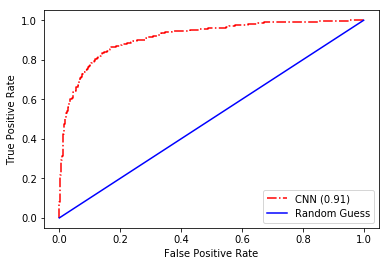

In [18]:
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), y_pred_proba[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

In [20]:
model.summary()
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 115202    
Total params: 134,018
Trainable params: 134,018
Non-trainable params: 0
_________________________________________________________________


# Analysis of CNN weights

In [21]:
weights = model.get_weights()
print(np.shape(weights))
for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

(6,)
shape of weights[0]:  (3, 3, 1, 32)
shape of weights[1]:  (32,)
shape of weights[2]:  (3, 3, 32, 64)
shape of weights[3]:  (64,)
shape of weights[4]:  (57600, 2)
shape of weights[5]:  (2,)


In [22]:
weights[0][:,:,0,0]

array([[ 0.13215482,  0.09404028,  0.04295899],
       [-0.13720509,  0.01689352,  0.0709653 ],
       [-0.00976237,  0.1293589 , -0.02327806]], dtype=float32)

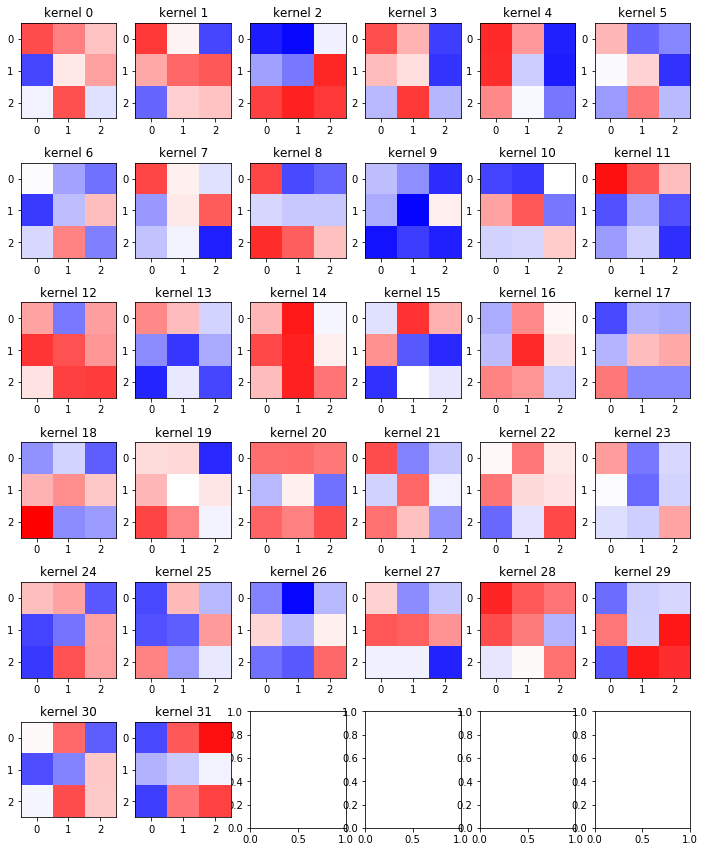

In [23]:
# kernels de la primera capa

nfilters = weights[0].shape[3]
lado = int(np.ceil(np.sqrt(nfilters)))
plt.subplots(lado,lado,figsize = (12, 15))

ma = abs(weights[0]).max()

for i in range(nfilters):
    kernel = weights[0][:,:,0,i]
    plt.subplot(lado,lado,i+1)
    plt.imshow(kernel, vmin=-ma, vmax=ma, cmap='bwr')
    plt.title('kernel %d' % i)
